### Lab Assignment 3: Calculating walking distances in Python

**Objectives:**
   * We will explore OpenStreetMap (OSM) data using <code>osmnx</code>.
   * Learn about OSM data stuctures
   * Compute walking distances using just a few lines of code
   * Export our data as a shapefile using <code>geopandas</code> 
   * Visualize our data in QGIS

We will be relying heavily on <code>osmnx</code> which is a package that enables automatic download of geospatial data from OSM and allows us to model, project, visualize, and analyze real-world street networks. More information about this package can be found [here](https://osmnx.readthedocs.io/en/stable/) and the [GitHub repo](https://github.com/gboeing/osmnx/tree/6f9236f20a81416bf34186a811a8ebb76afa0dc8)

We will start with a simple example that calculates the Euclidean distance between Condon Hall and some cafes in Eugene. After that, we will use the <code>networkx</code> package to calculate actual walking distances from Condon Hall to the cafes.

In [74]:
# Import modules
import osmnx as ox 

import numpy as np
import pandas as pd
import geopandas as gpd

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import LineString, MultiLineString

### Retrieve OSM data

First we will retrieve all features labelled (or tagged) as buildings in Eugene.

In [26]:
# Specify type of data
tags = {'building': True}

# Download building geometries from OSM
gdf = ox.geometries_from_place('Eugene, Oregon, USA', tags)

/opt/anaconda3/envs/lab3/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/opt/anaconda3/envs/lab3/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


It did not take long to download all this data even though this GeoDataFrame is massive (don't worry about the error message!). We can find the number of buildings in Eugene by printing the shape of the GeoDataFrame.

In [27]:
print(gdf.shape)

(55505, 227)


We can find out what attributes are contained in this GeoDataFrame by printing the column headers as a list. 

In [15]:
print(gdf.columns.tolist())

['addr:state', 'building', 'ele', 'gnis:county_id', 'gnis:created', 'gnis:feature_id', 'name', 'operator', 'geometry', 'access', 'wheelchair', 'source', 'ref', 'amenity', 'description', 'opening_hours', 'information', 'tourism', 'addr:city', 'addr:housenumber', 'addr:street', 'brand', 'brand:wikidata', 'brand:wikipedia', 'cuisine', 'takeaway', 'addr:postcode', 'bus', 'network', 'public_transport', 'fee', 'leisure', 'sport', 'material', 'emergency', 'nodes', 'building:levels', 'gnis:county_name', 'internet_access', 'shop', 'url', 'wikidata', 'wikipedia', 'name:ja', 'phone', 'website', 'air_conditioning', 'delivery', 'diet:vegan', 'denomination', 'religion', 'internet_access:fee', 'smoking', 'government', 'office', 'email', 'layer', 'location', 'man_made', 'payment:cash', 'payment:credit_cards', 'payment:debit_cards', 'drive_through', 'short_name', 'boundary', 'heritage', 'heritage:operator', 'nrhp:criteria', 'nrhp:inscription_date', 'nrhp:nhl', 'protection_title', 'ref:nrhp', 'name_1', 

Since OSM is entirely based on volunteered geographic information, there are a lot of attributes, most of which are not complete. We can find the number of non-NaNs in each column by typing:

In [37]:
# Count number of non-NaNs in each column
gdf.count()

addr:state                       562
building                       55505
ele                               25
gnis:county_id                    17
gnis:created                      18
gnis:feature_id                   25
name                            1212
operator                          59
geometry                       55505
access                            18
wheelchair                        36
source                           454
ref                                6
amenity                          501
description                       22
opening_hours                     99
information                        1
tourism                           54
addr:city                        704
addr:housenumber                1314
addr:street                     1221
brand                            212
brand:wikidata                   204
brand:wikipedia                  193
cuisine                          133
takeaway                          54
addr:postcode                   1060
b

For the purposes of this assignment, we are only interested in buildings that are tagged as **cafes**. Cafes are usually tagged as an **amenity** in OSM so we can filter them using a string comparison.

In [28]:
# Filter cafes
cafes = gdf[gdf['amenity'] == 'cafe'].reset_index()
display(cafes)

We find that there are 33 cafes in Eugene. This could well be an underestimate since there could be cafes that were not tagged as amenities when mapped. But let's keep moving forward. 

### Computing Euclidean distances to cafes from Condon Hall

We now want to compute the distance to ten nearest cafes. First we will have to reproject our data to UTM Zone 10N which is a projection system that contains Oregon (https://epsg.io/32610)

In [36]:
# Reproject to UTM Zone 10N
gdf = gdf.to_crs('EPSG:32610')
cafes = cafes.to_crs('EPSG:32610')

Find the coordinates of Condon Hall by searching for **Condon Hall** in the original GeoDataFrame.

In [38]:
# Get coordinates of Condon Hall
condon_hall = gdf[gdf['name'] == 'Condon Hall'].reset_index()

Compute building centroids so we can compute point-to-point distances.

In [39]:
# Get cafe and Condon Hall centroids
cafes['centroid'] = cafes['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

condon_hall['centroid'] = condon_hall['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

Now we can compute the Euclidean distances between Condon Hall and the cafes

In [40]:
# Compute distances
condon_hall_x = condon_hall['centroid'].x.values[0]
condon_hall_y = condon_hall['centroid'].y.values[0]
distances = np.sqrt(((condon_hall_x - cafes['centroid'].x.values)**2)
                     + ((condon_hall_y - cafes['centroid'].y.values)**2))

# Add to GeoDataFrame
cafes['euclidean_distance'] = distances

...and print a list of the ten closest cafes to Condon Hall

In [42]:
print(cafes.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance']])

                         name         dist
7   Greenleaf Juicing Company    53.254590
5               Espresso Roma   135.286656
10         Dutch Bros. Coffee   830.863412
16            The Rabbit Hole   994.588162
4                   Starbucks  1094.039455
2            Brail's Expresso  1225.004530
9             Voodoo Doughnut  1240.194485
15              Amazon Coffee  1296.503685
6          Dutch Bros. Coffee  1369.369747
32         Dutch Bros. Coffee  1519.719695


Finally, we will save as shapefile so we can visualize in QGIS

In [54]:
# Make a new DataFrame containing only the three most relevant columns
nearest_cafes = cafes.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance', 'centroid']]

# Set column geometry
nearest_cafes = nearest_cafes.set_geometry('centroid')

# Save to file
nearest_cafes.to_file('/path/to/nearest_cafes.shp') # Note that you will have to change the path to your student folder

### Question 1 (20 points):
Compute the Euclidean distance to another **amenity** of your choosing. Demonstrate where your ten nearest amenities are by copying and pasting your map to your answer sheet with a description of what your map shows. Make sure you change the **Symbology** of the layer so that your amenities can be easily located on an OSM basemap. *Note*: *feel free to use a place other than Eugene and Condon Hall*.

### Computing network distances to cafes from Condon Hall

Euclidean distances often underestimate the distance between two objects, especially when there are obstacles between the two. So we will now compute some more realistic distances to cafes around Condon Hall. First we will need to import the [<code>networkx</code>](https://networkx.org/) package which will allow us conduct a network analysis. 

In [55]:
# Import module
import networkx as nx

Now we will define the coordinates of Condon Hall and download a walkable street network from OSM. Since the furthest of our ten cafes was 1.5 km away, we will limit our download to 1.6 km.

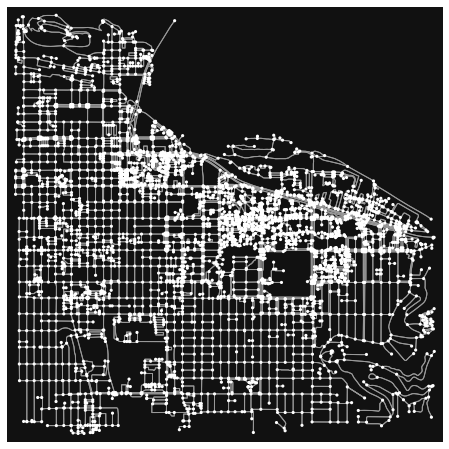

In [56]:
# Define coordinates of Condon Hall
lat_lon = (44.0451, -123.0781)

# Import walkable street network data around Condon Hall
g = ox.graph_from_point(lat_lon, dist=1600, network_type='walk')

# Plot map
fig, ax = ox.plot_graph(g, node_size=10)

In [57]:
# Convert to graph
graph_proj = ox.project_graph(g)

# Get edges and nodes separately
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [58]:
# Check projection is UTM Zone 10N
print("Coordinate system:", edges_proj.crs)

Coordinate system: +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


In [85]:
# Get x and y coordinates of Condon Hall
orig_xy = (condon_hall['centroid'].y.values[0], condon_hall['centroid'].x.values[0])

# Get x and y coordinates of one of the cafes (the furthest of the ten)
target_xy = (nearest_cafes['centroid'].y.values[-1], nearest_cafes['centroid'].x.values[-1])

In [86]:
# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node = ox.distance.nearest_nodes(G=graph_proj, X=orig_xy[1], Y=orig_xy[0], return_dist=False)

# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

In [87]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')

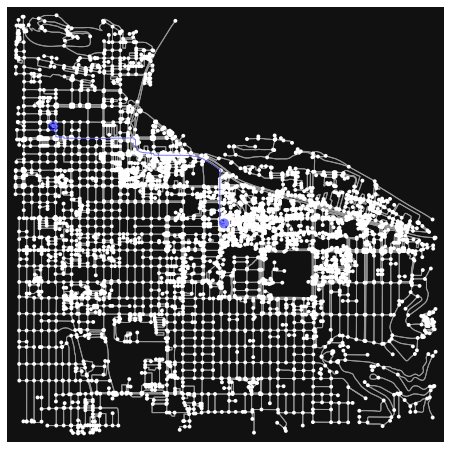

In [88]:
# Plot the shortest path
fig, ax = ox.plot_graph_route(graph_proj, route, route_color='blue', 
                              route_linewidth=1)

In [99]:
# Get the nodes along the shortest path
route_nodes = nodes_proj.loc[route]

# Create a geometry for the shortest path
route_line = LineString(list(route_nodes['geometry'].values))

# Create a GeoDataFrame
route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

# Print length of route
print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[-1], route_geom['geometry'].length / 1000))

Walking distance to Dutch Bros. Coffee = 1.9 km


OK that looks very nice, but what about if we wanted distances to all ten cafes. We need to put this code into a for loop.

In [93]:
# Get x and y coordinates of all ten of the nearest cafes
target_xy = (nearest_cafes['centroid'].y.values, nearest_cafes['centroid'].x.values)

In [110]:
routes = []
distances = []
for i in range(len(target_xy[0])):
    
    # Find the node in the graph that is closest to the target point (here, we want to get the node id)
    target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1][i], Y=target_xy[0][i], return_dist=False)
    
    # Calculate the shortest path
    route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')
    
    # Append route to list
    routes.append(route)
    
    # Get the nodes along the shortest path
    route_nodes = nodes_proj.loc[route]
    
    # Create a geometry for the shortest path
    route_line = LineString(list(route_nodes['geometry'].values))

    # Create a GeoDataFrame
    route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

    # Print length of route
    print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[i], route_geom['geometry'].length / 1000))
    
    # Append distances to list
    distances.append(route_geom['geometry'].length[0])
    
    # Export MultiString to shapefile
    geoms = [edges_proj.loc[(u, v, 0), 'geometry'] for u, v in zip(route[:-1], route[1:])]
    gdf = gpd.GeoDataFrame(geometry=[MultiLineString(geoms)], crs=edges_proj.crs)
    path_name = '/Users/jryan4/Dropbox (University of Oregon)/Teaching/geospatial-data-science/labs/lab3/data/'
    gdf.to_file(path_name + 'route_' + str(i) + '.shp')

Walking distance to Greenleaf Juicing Company = 0.2 km
Walking distance to Espresso Roma = 0.2 km
Walking distance to Dutch Bros. Coffee = 1.1 km
Walking distance to The Rabbit Hole = 1.4 km
Walking distance to Starbucks = 1.2 km
Walking distance to Brail's Expresso = 1.6 km
Walking distance to Voodoo Doughnut = 1.6 km
Walking distance to Amazon Coffee = 1.7 km
Walking distance to Dutch Bros. Coffee = 1.5 km
Walking distance to Dutch Bros. Coffee = 1.9 km


Let's add the network distances to the original DataFrame and export as a csv file.

In [115]:
nearest_cafes['network_distance'] = distances

path_name = '/Users/jryan4/Dropbox (University of Oregon)/Teaching/geospatial-data-science/labs/lab3/data/'
nearest_cafes.to_csv(path_name + 'distances.csv')

### Question 2 (10 points): 
* a) What is the average difference between the Euclidean and network distances? 
* b) Describe some examples where it would not be advisable to use Euclidean distances?

### Question 3 (20 points): 
Adapt the code above to compute the network distance between two points (either in Eugene or in a city of your choice). Export the route as a shapefile, make a map showing the route, and provide a short description. Again, make sure you change the **Symbology** of the route so that it is easily located on an OSM basemap.